Consider $I = \int\limits_a^b dx f(x)$

We want to evaluate this integral using $I_N = \frac{b-a}{N} \sum_{i=1}^{N} f(x_i)$

Standard deviation: $\sigma_N = (b-a) \sqrt{\frac{\langle f^2 \rangle_N - \langle f \rangle^2_N}{N-1}}$

For $f(x) = x^4, a=0, b=1, N=1000$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import pandas as pd
from scipy.stats import norm

In [3]:
def monte_carlo_estimator(a,b,N, func):
    random_numbers = np.random.rand(N)
    v_list = [func(x) for x in random_numbers]
    I_estimated = ((b-a)/N)*np.sum(v_list)
    v_squared = [np.power(func(x), 2) for x in random_numbers]
    var = np.mean(v_squared) - np.power(np.mean(v_list),2)
    err = (b-a)*np.sqrt((var)/(N-1))
    return I_estimated, err, random_numbers

def f(x):
    return np.power(x, 4)

In [4]:
np.random.seed(42)
I_mc, sigma_mc, _ = monte_carlo_estimator(0,1,1000,f)
print("The monte carlo estimator yields:\n $I_{1000}$ = " , I_mc,
      "\n $\sigma_{1000}$ = ", sigma_mc)

The monte carlo estimator yields:
 $I_{1000}$ =  0.195487744775144 
 $\sigma_{1000}$ =  0.008405982001502853


The exact solution can be calculated analytically:

$I = \int\limits_0^1 dx  x^4 = \frac{1}{5} x^5 |_0^1 = \frac{1}{5} - 0 = \frac{1}{5}$ 



In [5]:
def sigma_diff(I_est, I_true, sigma):
    return np.abs(I_est - I_true)/ sigma

confidence_interval = (1/5 - sigma_mc, 1/5 + sigma_mc)

probability_lower = norm.cdf(I_mc, loc=1/5, scale=sigma_mc)
probability_upper = norm.cdf(1/5+ sigma_mc*sigma_diff(I_mc, 1/5, sigma_mc), loc=1/5, scale=sigma_mc)

alpha = 100*(probability_upper - probability_lower)
alpha = "%.2f"% alpha

print(f"Comparing with the monte carlo estimation, the results are different by {sigma_diff(I_mc, 1/5, sigma_mc)} standard deviations. This means that the monte carlo estimation lies in the {alpha}%-confidence interval around the true value, I = 0.2.")

Comparing with the monte carlo estimation, the results are different by 0.5367909691038236 standard deviations. This means that the monte carlo estimation lies in the 40.86%-confidence interval around the true value, I = 0.2.


Repeat your calculation of $I_N$ with $M = 1000$ different sets of random numbers.
Plot a histogram of the resulting $I_N$ and fit a Gaussian distribution. Compare the
standard error σ you obtain for the Gaussian distribution with the Monte-Carlo
estimator of the standard error of $I_N$ found in part a).

In [6]:
#np.random.seed(42)
#seeds = np.random.randint(0, 100000, size=1000)
#np.save("seeds_1000", seeds)

In [7]:
seeds = np.load("seeds_1000.npy")

list_I = []
list_sigma = []

for m in range(1000):
    np.random.seed(seeds[m])
    I_m, sigma_m, _ = monte_carlo_estimator(0,1,1000,f)
    list_I.append(I_m)
    list_sigma.append(sigma_m)
list_I = np.array(list_I)
list_sigma = np.array(list_sigma)

In [8]:
vals, bins = np.histogram(list_I, bins=100)

bin_centres = [bins[n]+0.5*(bins[n+1]-bins[n]) for n in range(len(bins)-1)]

def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu) / sigma)** 2 / 2)
popt, cov = curve_fit(gaussian, bin_centres, vals)

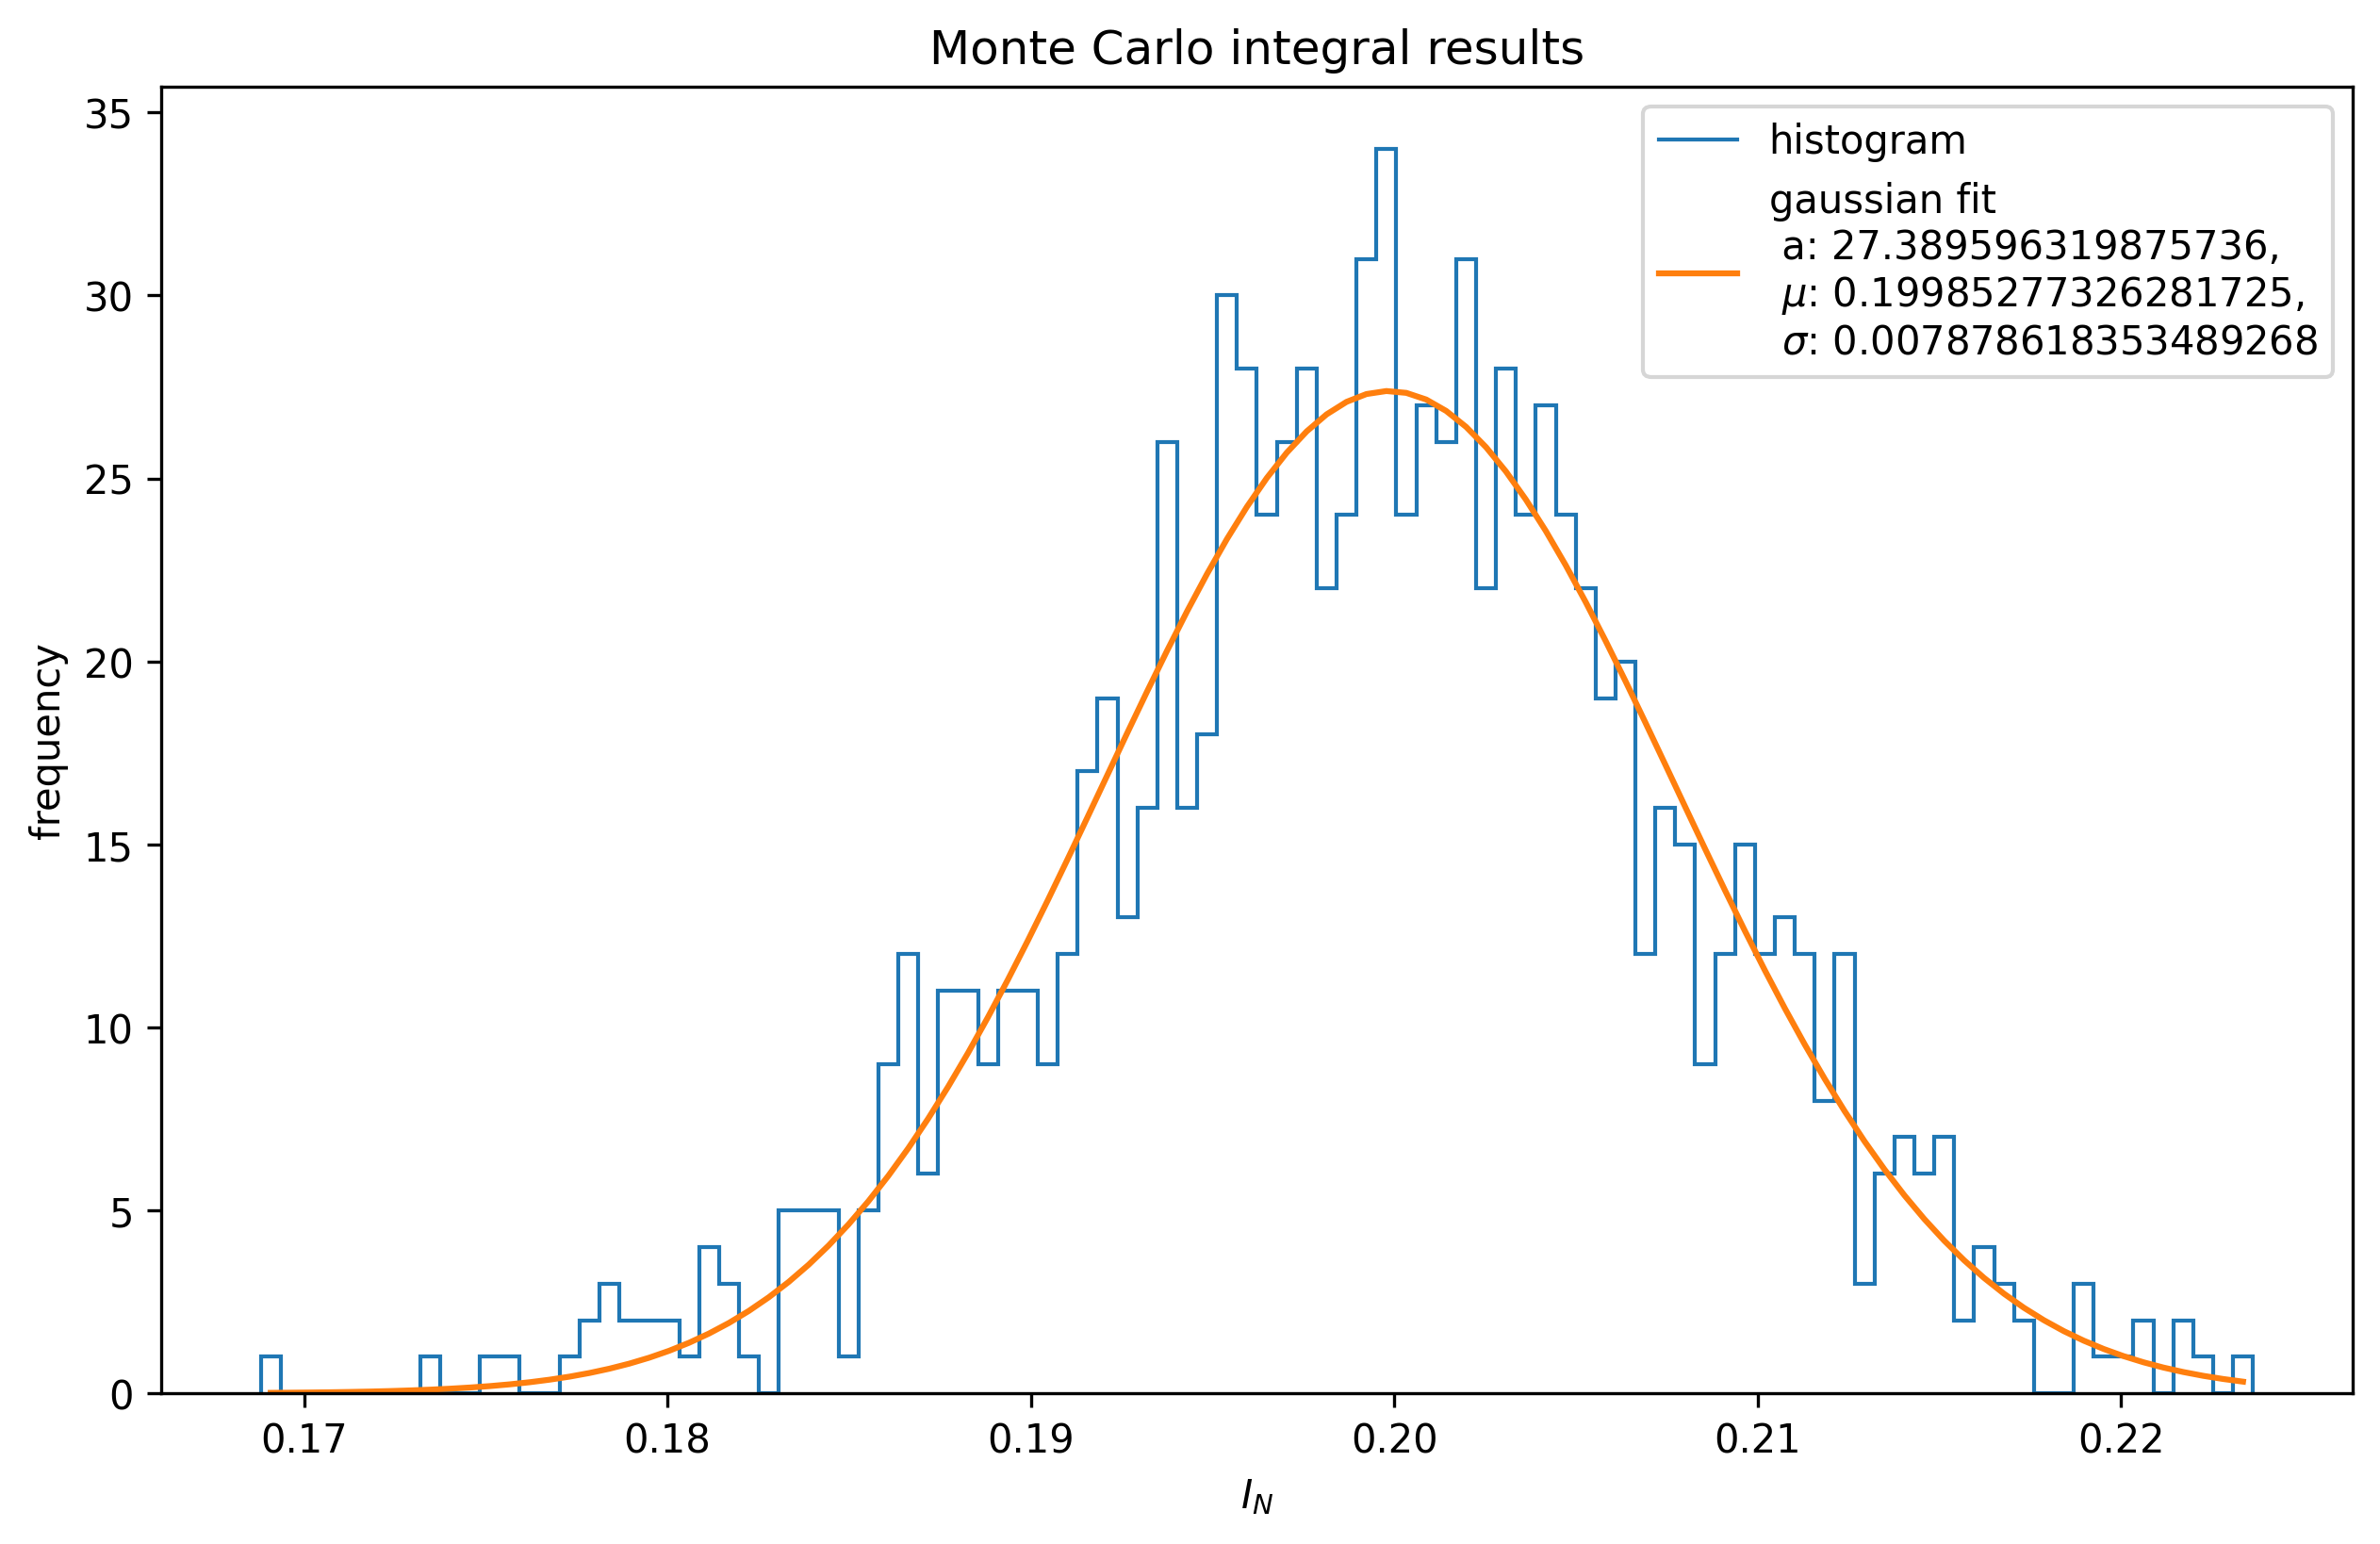

In [9]:
fig = plt.figure(figsize=(10, 6), dpi=300)
plt.stairs(vals, bins, label="histogram")
plt.plot(bin_centres, gaussian(bin_centres, *popt), label=f"gaussian fit \n a: {popt[0]}, \n $\mu$: {popt[1]}, \n $\sigma$: {popt[2]}")
plt.title("Monte Carlo integral results")
plt.xlabel("$I_N$")
plt.ylabel("frequency")
plt.legend(loc="best")
plt.show()

In [10]:
#Comparison with standard deviation from monte carlo
print("$\sigma_M$ =",sigma_mc, "\n $\sigma_Gauss$ =", popt[2], "\n Comparison: The standard errors from the Monte carlo method and Gaussian fit resemble each other well, indicating that the gaussian fit is appropriate.")

$\sigma_M$ = 0.008405982001502853 
 $\sigma_Gauss$ = 0.007878618353489268 
 Comparison: The standard errors from the Monte carlo method and Gaussian fit resemble each other well, indicating that the gaussian fit is appropriate.


Improve your Monte-Carlo integrator using importance sampling. As sampling distributions, use $g(x) = 2x, 3x^2, 4x^3$ and $5x^4$ For each $g(x)$, calculate $I_N$ and $σ_N$ as above and report your results (e.g. in a table or plot). Additionally, make a log-log plot of $σ_N$ versus $N$ for each $g(x)$. Discuss your results.

In [11]:
def g1(x):
    return 2*x#, 3 * x**2, 4 * x**3, 5 * x**4

def g2(x):
    return 3 * x**2

def g3(x):
    return 4 * x**3

def g4(x):
    return 5 * x**4

def G1(x):
    return x**2

def G2(x):
    return x**3 

def G3(x):
    return x**4 

def G4(x):
    return x**5

def G1i(x):
    return np.sqrt(x)

def G2i(x):
    return np.power(x, 1/3)

def G3i(x):
    return np.power(x, 1/4)

def G4i(x):
    return np.power(x, 1/5)

#def root_functions(func, x): #G and G inverse
 #   prefactor = func(1)
  #  return np.power(x, prefactor) , np.power(x, 1/prefactor)

list_g = [g1, g2, g3, g4]
list_G = [G1, G2, G3, G4]
list_Gi = [G1i, G2i, G3i, G4i]

array_g = np.array([list_g, list_G, list_Gi]).transpose()

np.random.seed(42)
def improved_monte_carlo(a,b,N,func, sampling_dist, G, G_inverse):
    random_numbers = np.random.rand(N) #N uniformly distributed random variables
    random_numbers_transformed = []
    for i in random_numbers:
        G_xmin = G(a)
        G_xmax = G(b)
        p = G_xmin+i*(G_xmax-G_xmin)
        x = G_inverse(p)
        random_numbers_transformed.append(x)
    v_list = [func(x)/sampling_dist(x) for x in random_numbers_transformed]
    I_estimated = ((b-a)/N)*np.sum(v_list)
    v_squared = [np.power(func(x), 2) for x in random_numbers]
    var = np.mean(v_squared) - np.power(np.mean(v_list),2)
    err = (b-a)*np.sqrt((var)/(N-1))
    return I_estimated, err, random_numbers

dict_results={"sampling distribution": ["2x", "3x^2", "4x^3", "5x^4"], 
              "I_N":[],
              "\sigma_N":[]}

for g in array_g:
    i, s, _ = improved_monte_carlo(0,1,1000,f,g[0], g[1], g[2])
    dict_results["I_N"].append(i)
    dict_results["\sigma_N"].append(s)
    
df_results = pd.DataFrame(dict_results)
df_results

,sampling distribution,I_N,\sigma_N
0,2x,0.195558,0.008404
1,3x^2,0.201776,0.008701
2,4x^3,0.199819,0.008583
3,5x^4,0.200000,0.007889


In [16]:
print(f"Discussion: The solution for the monte carlo integration with non-transformed random variables, I={np.round(I_mc, 3)} (standard deviation: {np.round(sigma_mc, 3)}) is comparable with the results with sampling distributions. Using sampling distribution f(x) = 5x^4, the result is best.") 

Discussion: The solution for the monte carlo integration with non-transformed random variables, I=0.195 (standard deviation: 0.008) is comparable with the results with sampling distributions. Using sampling distribution f(x) = 5x^4, the result is best.
